# Session 4: Advanced Universe Creation and Attributes

<a id='trajanalysis'></a>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

Authors: 

- Dr Micaela Matta - [@micaela-matta](https://github.com/micaela-matta)
- Dr Richard Gowers - [@richardjgowers](https://github.com/richardjgowers) 

This notebook is adapted from materials developed for the [2018 Workshop/Hackathon](https://github.com/MDAnalysis/WorkshopHackathon2018).

## Learning Outcomes


This notebook contains examples of more complicated `Universe` construction.


#### Additional resources

 - During the workshop, feel free to ask questions at any time
 - For more on how to use MDAnalysis, see the [User Guide](https://userguide.mdanalysis.org/2.0.0-dev0/) and [documentation](https://docs.mdanalysis.org/2.0.0-dev0/)
 - Ask questions on the [GitHub Discussions forum](https://github.com/MDAnalysis/mdanalysis/discussions) or on [Discord](https://discord.gg/fXTSfDJyxE)
 - Report bugs on [GitHub](https://github.com/MDAnalysis/mdanalysis/issues?)


# Google Colab package installs

This installs the necessary packages for Google Colab. Please only run these if you are using Colab.

In [ ]:
# NBVAL_SKIP
!pip install condacolab
import condacolab


In [ ]:
# NBVAL_SKIP
import condacolab
condacolab.check()
!mamba install -c conda-forge mdanalysis mdanalysistests mdanalysisdata nglview rdkit

In [ ]:
# NBVAL_SKIP
# enable third party jupyter widgets
from google.colab import output
output.enable_custom_widget_manager()

In [1]:
import warnings
warnings.filterwarnings("ignore") 

import MDAnalysis as mda
import MDAnalysisData as data


/Users/richard/mambaforge/envs/mda_workshop/lib/python3.11/site-packages/MDAnalysisData/base.py:34: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_string


## 1. `transfer_to_memory`

The MDAnalysis data model only loads a single frame of trajectory data into memory at any point.  This is because loading an entire trajectory at once would require a large amount of memory.

Using the `in_memory` keyword in `Universe` creation, (or calling the `Universe.transfer_to_memory()` method,
the entire trajectory can be read into memory.
This will require significantly more memory on the workstation,
typically a similar amount to the filesize of the trajectory.

In [2]:
adk = data.datasets.fetch_adk_equilibrium()

In [3]:
regular_u = mda.Universe(adk['topology'], adk['trajectory'])

%timeit [ts.frame for ts in regular_u.trajectory]

/Users/richard/mambaforge/envs/mda_workshop/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


155 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Iterating through a trajectory can be much faster without having to read from the trajectory file for each frame.

In [4]:
memory_u = mda.Universe(adk['topology'], adk['trajectory'], in_memory=True)

%timeit [ts.frame for ts in memory_u.trajectory]

4.36 ms ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Transferring a trajectory to memory converts the `Universe.trajectory` object to a `MemoryReader`.
One notable difference of this `Reader` is any changes made to atom positions are permanent!
This can be useful when you want to apply a coordinate transformation (ie align the structure) and then analyse afterwards.

In [5]:
print(memory_u.trajectory)

<MemoryReader with 4187 frames of 3341 atoms>


## 2. `guess_bonds`

By default, bond information is only present in a `Universe` if the topology file had these.
This means that various methods such as `.fragments` will not work

In [6]:
nhaa = data.datasets.fetch_nhaa_equilibrium()

nhaa_u = mda.Universe(nhaa['topology'])

nhaa_u.atoms.fragments

NoDataError: AtomGroup.fragments not available; this requires bonds

It is possible to try and guess bonds based upon the separations between atoms.
Bonds are guessed by comparing the distance between two atoms ($d_{ij}$) to the sum of their vdw radii ($r$) multiplied by a fudge factor ($f = 0.72$ by default).

$$ d_{ij} <= f * (r_i + r_j) $$

Some vdw_radii are built in to `MDAnalysis`, however any missing radii can be given via the `vdwradii` keyword:

In [7]:
nhaa_u = mda.Universe(nhaa['topology'], guess_bonds=True)

In [8]:
nhaa_u = mda.Universe(nhaa['topology'], guess_bonds=True, vdwradii={'CL': 2.0, 'NA': 2.0})

In [9]:
nhaa_u.atoms.fragments

(<AtomGroup with 5807 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 5812 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup with 127 atoms>,
 <AtomGroup wi

## 3. ChainReader

MD Trajectories are often created in a series of discrete simulations.
By supplying a list of trajectory filenames to `Universe` creation,
these will be read in sequence by the `ChainReader` class.

In [10]:
adk_dims = data.datasets.fetch_adk_transitions_DIMS()

print(adk_dims['trajectories'][:5])

['/Users/richard/MDAnalysis_data/adk_transitions_DIMS/DIMS/trajectories/dims0138_fit-core.dcd', '/Users/richard/MDAnalysis_data/adk_transitions_DIMS/DIMS/trajectories/dims0192_fit-core.dcd', '/Users/richard/MDAnalysis_data/adk_transitions_DIMS/DIMS/trajectories/dims0048_fit-core.dcd', '/Users/richard/MDAnalysis_data/adk_transitions_DIMS/DIMS/trajectories/dims0195_fit-core.dcd', '/Users/richard/MDAnalysis_data/adk_transitions_DIMS/DIMS/trajectories/dims0180_fit-core.dcd']


In [11]:
chain_u = mda.Universe(adk_dims['topology'], adk_dims['trajectories'])

In [12]:
print(chain_u.trajectory)

<ChainReader containing dims0138_fit-core.dcd and 199 more with 19691 frames of 3341 atoms>


## 4. `fetch_mmtf`

You can load structures from the Protein Data Bank using the `fetch_mmtf` method.
This will download the `mmtf` data from the PDB, and create a Universe from this:

In [13]:
u = mda.fetch_mmtf('5YVL')

print(u)

<Universe with 6799 atoms>


## 5. Creating new systems with MDAnalysis

Whilst `MDAnalysis` is designed for reading pre existing simulation files, there is also some features which allow the construction of systems

### Universe.empty and adding new attributes

The `Universe` object can also be constructed from the `Universe.empty` method, which is similar to `np.zeros`.

In [14]:
mda.Universe.empty?

Here we create an 20 atom Universe, with a trajectory attached.  The positions of all atoms will initially be zero

In [15]:
u = mda.Universe.empty(n_atoms=21, n_residues=7,
                       trajectory=True)

In [16]:
print(u.atoms)
print(u.residues)

<AtomGroup [<Atom 1:>, <Atom 2:>, <Atom 3:>, ..., <Atom 19:>, <Atom 20:>, <Atom 21:>]>
<ResidueGroup [<Residue>, <Residue>, <Residue>, <Residue>, <Residue>, <Residue>, <Residue>]>


In [17]:
print(u.atoms.positions)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [18]:
for i, res in enumerate(u.residues):
    u.atoms[i * 3: (i + 1) * 3].residue = res

We can then add various topology attributes to these atoms:

In [19]:
u.add_TopologyAttr('masses', values=[10.0] * 21)
u.add_TopologyAttr('names', values=['A'] * 21)
u.add_TopologyAttr('types', values=['Ca'] * 21)
u.add_TopologyAttr('resids', values=range(7))

In [20]:
u.atoms.masses

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10.])

And finally we can write this `Universe` out to a file:

In [21]:
u.atoms.write('new.gro')

In [22]:
!head new.gro

Written by MDAnalysis
   21
    0UNK      A    1   0.000   0.000   0.000
    0UNK      A    2   0.000   0.000   0.000
    0UNK      A    3   0.000   0.000   0.000
    0UNK      A    4   0.000   0.000   0.000
    0UNK      A    5   0.000   0.000   0.000
    0UNK      A    6   0.000   0.000   0.000
    0UNK      A    7   0.000   0.000   0.000
    0UNK      A    8   0.000   0.000   0.000


# Selecting hydrophobic/hydrophilic groups

In [23]:
adk = data.datasets.fetch_adk_equilibrium()

In [24]:
u = mda.Universe(adk.topology, adk.trajectory)

In [25]:
u.select_atoms('resname SER TYR THR')

<AtomGroup with 356 atoms>

In [26]:
u.select_atoms('resname ALA VAL LEU ILE PRO PHE CYS')

<AtomGroup with 1315 atoms>

# Custom attributes and selecting them

Can I add an entirely new property to a universe?

This is technically possible, but is a bit at the edges of what is recommended...

In [27]:
from MDAnalysis.core.topologyattrs import AtomAttr
import numpy as np

In [28]:
u = mda.Universe(adk.topology, adk.trajectory)

We need to define a new `AtomAttr`, which has several special fields that must also be defined.
These are used to define the extra attributes which are added to the `AtomGroup` objects that are created by a particular Universe.

In [29]:
class Bounciness(AtomAttr):
    dtype=bool
    attrname='bounciness'
    singular='bouncy'
    per_object='atom'

In [30]:
# this adds a TopologyAttr, where all atoms initially have False as their bouncy value
u.add_TopologyAttr(Bounciness(np.zeros_like(u.atoms)))

In [31]:
# this attribute is now accessible via the AtomGroup objects
u.atoms.bounciness

array([False, False, False, ..., False, False, False])

In [32]:
# and is also selectable via the select_atoms mini language
u.select_atoms('bouncy')

<AtomGroup with 0 atoms>

In [33]:
# for testing, lets set every other atom to be considered "bouncy"
u.atoms[::2].bounciness = True

In [34]:
# and we can then see we can select backbone atoms that were arbitrarily tagged as bouncy
u.select_atoms('bouncy and backbone').indices

array([   0,    4,   18,   42,   60,   62,   64,   80,   98,  100,  102,
        118,  124,  126,  128,  134,  136,  140,  148,  150,  152,  156,
        166,  172,  174,  176,  194,  196,  198,  202,  216,  232,  234,
        236,  242,  244,  246,  260,  280,  298,  300,  302,  316,  330,
        332,  334,  352,  354,  356,  374,  380,  382,  384,  400,  414,
        430,  432,  434,  450,  460,  462,  464,  474,  476,  478,  482,
        494,  510,  512,  514,  530,  554,  564,  574,  590,  612,  622,
        624,  626,  630,  640,  642,  644,  656,  674,  676,  678,  682,
        704,  720,  722,  724,  730,  732,  734,  752,  754,  756,  764,
        766,  768,  784,  800,  802,  804,  812,  814,  816,  822,  824,
        826,  830,  852,  870,  872,  874,  886,  888,  890,  900,  902,
        904,  912,  914,  916,  928,  946,  948,  950,  962,  964,  966,
        982,  992, 1010, 1012, 1014, 1026, 1028, 1030, 1048, 1050, 1052,
       1064, 1088, 1106, 1108, 1110, 1116, 1118, 11

## Adding dummy atoms to a Universe

In general the number of atoms within a Universe must remain constant.
It is however possible to merge two Universes (`mda.Merge`)
and this can be used with `mda.Empty` to "extend" a Universe with dummy atoms.

In [35]:
# first create a regular Universe from files
u = mda.Universe(adk.topology, adk.trajectory)

In [36]:
# then 
dummy_u = mda.Universe.empty(n_atoms=10)
dummy_u.add_TopologyAttr('names', ['DUMMY'] * 10)

In [37]:
new_u = mda.Merge(u.atoms, dummy_u.atoms)

In [39]:
# a merged Universe will only retain any atom attributes which *both* Universes have
new_u._topology.attrs

In [40]:
new_u.atoms[-10:].names

array(['DUMMY', 'DUMMY', 'DUMMY', 'DUMMY', 'DUMMY', 'DUMMY', 'DUMMY',
       'DUMMY', 'DUMMY', 'DUMMY'], dtype=object)

## Writing out a Universe without any solvent

In [41]:
from MDAnalysisTests.datafiles import TPR, TRR

In [49]:
u = mda.Universe(TPR, TRR)

print(len(u.atoms))

47681


In [50]:
not_water = u.atoms.select_atoms('not resname SOL NA+')
not_water

<AtomGroup with 3341 atoms>

In [51]:
# the signature for Writer is useful for understanding which arguments are required
mda.Writer?

In [45]:
with mda.Writer('dry.xtc', n_atoms=len(not_water)) as w:
    # we also write every 5th frame...
    for ts in u.trajectory[::5]:
        w.write(not_water)

In [46]:
# to be able to load this Universe, we also write a topology file (here a .gro)
not_water.write('dry.gro')

In [52]:
dry_u = mda.Universe('dry.gro', 'dry.xtc')

In [53]:
dry_u

<Universe with 3341 atoms>

# Creating systems using mda.Merge

We can also use `mda.Merge` to generate system volumes from scratch.

(This is probably better done by a tool like packmol...)

First we use rdkit to generate initial conformations for a propane molecule.

In [54]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [55]:
m = Chem.AddHs(Chem.MolFromSmiles('CCC'))
AllChem.EmbedMolecule(m)

0

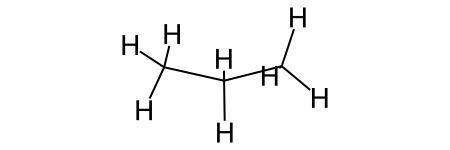

In [56]:
m

We can create a Universe from an rdkit Molecule.
Therefore we can then create multiple copies of a Universe using a list comprehension...

In [57]:
universes = [mda.Universe(m) for i in range(16)]

The `AtomGroup.translate` method allows us to shift these atoms.

Here we shift each Universe by 10 angstroms in the x-dimension.

In [58]:
for i, u in enumerate(universes):
    u.atoms.translate([i * 10, 0, 0])

In [59]:
fancy_u = mda.Merge(*[u.atoms for u in universes])

# Using AtomGroup.unwrap to unwrap trajectories

In [60]:
import nglview as nv

from MDAnalysis.lib.mdamath import make_whole

In [61]:
u = mda.Universe(TPR, TRR)


Calculating bond lengths without considering periodic boundary conditions shows us that there is apparently a bond with a length of 79A!
This is obviously caused by the two atoms being in separate periodic images.

In [62]:
u.atoms.bonds.values(pbc=False).max()

79.85327759926072

We can use the unwrap method to prevent any molecules being "split" over periodic images.

In [63]:
?u.atoms.unwrap

In [64]:
# use reference = center of geometry
u.atoms.unwrap(reference='cog')

array([[ 52.017067 ,  43.56005  ,  31.554958 ],
       [ 51.18792  ,  44.112053 ,  31.722015 ],
       [ 51.550823 ,  42.827724 ,  31.038803 ],
       ...,
       [105.341995 ,  74.072    ,  40.988003 ],
       [ 57.684002 ,  35.323997 ,  14.804    ],
       [ 62.961002 ,  47.239    ,   3.7529998]], dtype=float32)

After unwrapping our coordinates, the maximum observed bond length (when not considering periodic boundary conditions) is a sensible value.

In [65]:
u.atoms.bonds.values(pbc=False).max()

1.8100032684745506